In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table

from astropy.coordinates import SkyCoord
import astropy.units as u

import warnings

# Disable plotting warnings
warnings.filterwarnings("ignore")

In [2]:
FIELDS = {'ECDFS': (53.13, -28.10), 'EDFS':(59.10, -48.73), 'SV_38_7':(37.86, 6.98), 
          'SV_95_-25':(95.00, -25.00), '47Tuc':(6.02, -72.08), 'Fornax_dSph':(40.00, -34.45)}

def get_box(name, coords, df, size=1.5):
    ra, dec = coords
    sub = df.query(f'{dec - size} < dec < {dec + size}')
    sub = sub.query(f'{ra - size/np.cos(abs(dec)*np.pi/180)} < ra < {ra + size/np.cos(abs(dec)*np.pi/180)}')
    sub['field'] = name
    print(f'{ra - size/np.cos(abs(dec)*np.pi/180)} < ra < {ra + size/np.cos(abs(dec)*np.pi/180)}')
    return sub

# This notebook creates a combined x-ray catalog of all sources in 5 X-ray catalogs within 1.5deg of each DP1 field center

Note: this required the data/raw_xray_data directory to be populated with the 5 data files of each catalog  

CSC2.1: downloaded with CSCview

## Import CSC2.1 data

#### notes
ra	            double	deg	        source position, ICRS right ascension  
dec	            double	deg	        source position, ICRS declination   
err_ellipse_r0	double	arcseconds	major radius of the 95% confidence level position error ellipse  
err_ellipse_r1	double	arcseconds	minor radius of the 95% confidence level position error ellipse  
flux_aper	    double	ergs s-1 cm-2	aperture-corrected net energy flux derived from the longest block  
flux_aper_avg	double	ergs s-1 cm-2	aperture-corrected net energy flux averaged over all contributing obs  
flux_aper90	    double	ergs s-1 cm-2	aperture-corrected net energy flux inferred from the PSF 90% ECF aperture  
flux_powlaw_aperdouble	ergs s-1 cm-2	source region aperture model energy flux from absorbed power law model  
flux_bb_aper	double[6]	ergs s-1 cm-2	source region aperture model energy flux inferred from the canonical absorbed black body model [NH = NH(Gal); kT = 0.75 keV]   
flux_powlaw	double	ergs s-1 cm-2	net integrated 0.5-7.0 keV energy flux of the best fitting absorbed power-law model spectrum to the source region aperture PI spectrum  

ACIS science energy bands (keV): b (0.5-7.0), u (0.2-0.5), s (0.5-1.2), m (1.2-2.0), h (2.0-7.0)  


HRC source detection and science energy band (keV): w (~0.1-10.0)



CHOOSE flux_aper90:	aperture-corrected net energy flux inferred from the PSF 90% ECF aperture


link to documentation: https://cxc.cfa.harvard.edu/csc/columns/

In [3]:
csc = pd.read_csv('../../data/raw_data/cscresults.2.tsv', comment='#', sep='\t')

In [4]:
csc.head()

,name,ra,dec,err_ellipse_r0,err_ellipse_r1,err_ellipse_ang,significance,likelihood_class,conf_flag,sat_src_flag,...,flux_aper90_s,flux_aper90_lolim_s,flux_aper90_hilim_s,flux_aper90_u,flux_aper90_lolim_u,flux_aper90_hilim_u,flux_aper90_w,flux_aper90_lolim_w,flux_aper90_hilim_w,flux_aper_avg_hilim_w
0,2CXO J000000.0+004331,23 59 59.99,+00 43 30.94,0.61,0.50,40.3,3.65,TRUE,FALSE,FALSE,...,1.040e-15,5.601e-16,1.494e-15,,,,,,,
1,2CXO J000000.1+623124,00 00 00.14,+62 31 24.25,1.43,1.22,158.7,3.41,TRUE,FALSE,FALSE,...,0.000e+00,0.000e+00,5.283e-16,,,,,,,
2,2CXO J000000.2-501250,00 00 00.19,-50 12 50.43,1.73,1.73,0.0,2.75,TRUE,FALSE,FALSE,...,,,,,,,,,,
3,2CXO J000000.3+321702,00 00 00.36,+32 17 02.89,1.25,0.82,88.3,3.20,TRUE,FALSE,FALSE,...,0.000e+00,0.000e+00,8.056e-16,0.000e+00,0.000e+00,3.633e-12,,,,
4,2CXO J000000.5+321232,00 00 00.53,+32 12 32.77,1.28,0.54,170.6,2.76,TRUE,FALSE,FALSE,...,2.062e-14,9.225e-15,3.147e-14,,,,,,,


In [5]:
pos_neg = {'+': 1, '-': -1}
get_ra = lambda row: np.dot(np.array([float(x) for x in row['ra'].strip().split(' ')]),  np.array([1, 1/60, 1/3600])) * 15
get_dec = lambda row: pos_neg[row['dec'][0]] * np.dot(np.array([float(x) for x in row['dec'].strip()[1:].split(' ')]),  np.array([1, 1/60, 1/3600]))


In [6]:
csc['raDEG'] = csc.apply(get_ra, axis=1)
csc['decDEG'] = csc.apply(get_dec, axis=1)

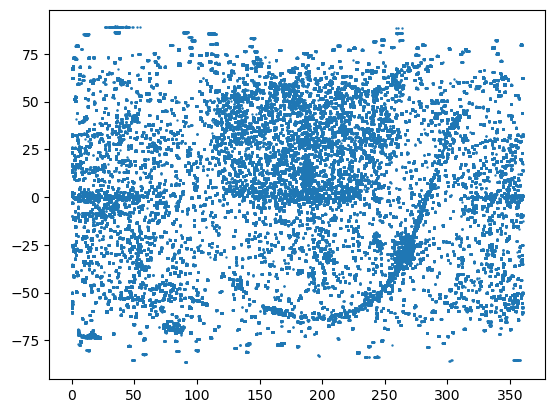

In [7]:
plt.scatter(csc['raDEG'], csc['decDEG'], s=.5)

In [8]:
csc.dtypes

name                      object
ra                        object
dec                       object
err_ellipse_r0           float64
err_ellipse_r1           float64
                          ...   
flux_aper90_lolim_w       object
flux_aper90_hilim_w       object
flux_aper_avg_hilim_w     object
raDEG                    float64
decDEG                   float64
Length: 72, dtype: object

In [9]:
csc.rename({'ra': 'ra_', 'dec': 'dec_', 'raDEG': 'ra', 'decDEG': 'dec'}, axis=1, inplace=True)
csc['e_pos'] = csc['err_ellipse_r0']

In [10]:
dp1_csc = pd.concat([get_box(name, coords, csc) for name, coords in FIELDS.items()])
dp1_csc['catalog'] = 'CSC2.1'

51.4295643168973 < ra < 54.830435683102706
56.82592280930308 < ra < 61.37407719069692
36.348799939622026 < ra < 39.37120006037797
93.34493312155627 < ra < 96.65506687844373
1.1449439201695437 < ra < 10.895056079830455
38.18098067763386 < ra < 41.81901932236614


In [11]:
dp1_csc['flux_aper90_avg_b'].value_counts().index

Index(['0.000e+00', '         ', '1.355e-15', '5.440e-15', '2.769e-14',
       '1.098e-14', '1.815e-15', '2.446e-15', '2.035e-15', '1.410e-15',
       ...
       '3.429e-17', '1.205e-14', '5.354e-17', '3.298e-17', '1.037e-16',
       '1.361e-14', '3.027e-16', '1.677e-17', '1.539e-17', '2.072e-16'],
      dtype='object', name='flux_aper90_avg_b', length=1650)

In [12]:
dp1_csc['flux_aper90_avg_b'].replace('         ', np.nan, inplace=True)
dp1_csc['flux'] = dp1_csc['flux_aper90_avg_b'].astype(float)

In [13]:
del csc

In [14]:
data_dict = {}
data_dict['CSC2.1'] = dp1_csc

## Read in 4XMMDR14

#### Notes
1       =       0.2 -   0.5 keV  
2       =       0.5 -   1.0 keV  
3       =       1.0 -   2.0 keV  
4       =       2.0 -   4.5 keV  
5       =       4.5 -  12.0 keV  

6       =       0.2 -   2.0 keV                 soft band, no images made  
7       =       2.0 -  12.0 keV                 hard band, no images made  
8       =       0.2 -  12.0 keV                 total band  
9       =       0.5 -   4.5 keV                 XID band  

EP_1_Flux     The EPIC band 1 flux (erg/cm2/s) (same for 2, 3, ..., 8, 9)  
PN_1_Flux     The PN band 1 flux (erg/cm2/s). (same for 2, 3, ..., 8, 9)  
M1_1_Flux  
M1_2_Flux  
PN_1_Det_ML    The PN band 1 detection likelihood.  

EP_HR1  
The EPIC hardness ratio HR1 for bands 1 and 2. The hardness ratios for each camera are derived by the SAS task emldetect. They are defined as the ratio between the bands A and B:  

              HR(A,B) = (band B - band A) / (band A + band B).  
              
HR1: bands 1 & 2  
HR2: bands 2 & 3  
HR3: bands 3 & 4  
HR4: bands 4 & 5  

1.0714*RADEC_ERR is 1 sigma error  

http://xmmssc.irap.omp.eu/Catalogue/4XMM-DR14/col_slimline.html


https://heasarc.gsfc.nasa.gov/W3Browse/xmm-newton/xmmssc.html

In [15]:
hdus = fits.open('../../data/raw_data/4XMM_slim_DR14cat_v1.0.fits.gz')

In [16]:
xmm_slim = Table(hdus[1].data).to_pandas()

In [17]:
xmm_slim.head()

,SRCID,IAUNAME,SC_RA,SC_DEC,SC_POSERR,SC_DET_ML,SC_EP_1_FLUX,SC_EP_1_FLUX_ERR,SC_EP_2_FLUX,SC_EP_2_FLUX_ERR,...,SC_SUM_FLAG,SC_EP_8_FMIN,SC_EP_8_FMIN_ERR,SC_EP_8_FMAX,SC_EP_8_FMAX_ERR,MJD_FIRST,MJD_LAST,N_DETECTIONS,CONFUSED,WEBPAGE_URL
0,206931901010113,4XMM J000000.2-552106,0.000981,-55.351745,2.675982,8.038111,2.339110e-16,1.635321e-16,7.477733e-16,2.453910e-16,...,0,6.556074e-15,4.427009e-15,6.556074e-15,4.427009e-15,56086.742951,56087.588194,1,False,http://xmm-catalog.irap.omp.eu/source/20693190...
1,204033901010030,4XMM J000000.2+623123,0.001078,62.523116,2.167670,21.189760,4.822757e-17,7.869429e-17,8.126540e-18,1.083667e-16,...,0,6.721141e-15,1.810381e-15,6.721141e-15,1.810381e-15,54134.485278,54135.043600,1,False,http://xmm-catalog.irap.omp.eu/source/20403390...
2,201253101010082,4XMM J000000.3-250629,0.001297,-25.108317,2.453619,10.784710,1.653872e-16,2.115387e-16,1.422986e-15,4.341466e-16,...,0,6.078558e-15,4.037854e-15,6.078558e-15,4.037854e-15,51696.440880,51696.788090,1,False,http://xmm-catalog.irap.omp.eu/source/20125310...
3,208626409010038,4XMM J000000.3-601742,0.001366,-60.295115,2.244868,26.889570,6.988109e-16,3.162751e-16,1.330748e-15,3.893567e-16,...,0,5.074446e-15,2.703255e-15,5.074446e-15,2.703255e-15,58972.676377,58972.858889,1,False,http://xmm-catalog.irap.omp.eu/source/20862640...
4,206931901010049,4XMM J000000.5-552138,0.002201,-55.360745,2.174880,48.448448,8.864110e-16,2.371883e-16,1.695742e-15,3.329001e-16,...,0,1.819022e-14,6.476398e-15,1.819022e-14,6.476398e-15,56086.742951,56087.588194,1,False,http://xmm-catalog.irap.omp.eu/source/20693190...


In [18]:
xmm_slim.rename({'SC_RA': 'ra', 'SC_DEC': 'dec', 'SC_POSERR': 'e_pos', 'IAUNAME':'name'}, axis=1, inplace=True)


In [19]:
dp1_xmm = pd.concat([get_box(name, coords, xmm_slim) for name, coords in FIELDS.items()])


51.4295643168973 < ra < 54.830435683102706
56.82592280930308 < ra < 61.37407719069692
36.348799939622026 < ra < 39.37120006037797
93.34493312155627 < ra < 96.65506687844373
1.1449439201695437 < ra < 10.895056079830455
38.18098067763386 < ra < 41.81901932236614


In [20]:
dp1_xmm['catalog'] = '4XMMDR14'

In [21]:
dp1_xmm['flux'] = dp1_xmm['SC_EP_8_FLUX']

In [22]:
data_dict['4XMMDR14'] = dp1_xmm

## XMMSL3
RADEC_ERR is 1 sigma uncertainty



http://xmmssc.irap.omp.eu/Catalogue/XMMSL3/XMMSL3.html

http://xmmssc.irap.omp.eu/Catalogue/XMMSL3/XMMSL3_Catalogue_User_Guide.html#columns

In [23]:
xmmsl = pd.read_csv('../../data/raw_data/xmmsl3_v1.0.csv')

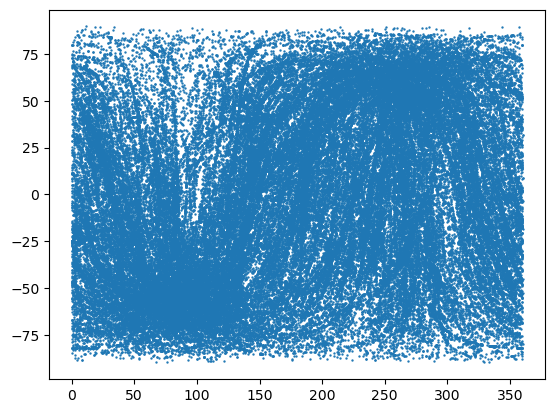

In [24]:
plt.scatter(xmmsl['ra'], xmmsl['dec'], s=.5)

In [25]:
xmmsl.rename({'radec_err': 'e_pos', 'unique_srcname':'name'}, axis=1, inplace=True)

In [26]:
dp1_xmmsl = pd.concat([get_box(name, coords, xmmsl) for name, coords in FIELDS.items()])
dp1_xmmsl['catalog'] = 'XMMSL3'

51.4295643168973 < ra < 54.830435683102706
56.82592280930308 < ra < 61.37407719069692
36.348799939622026 < ra < 39.37120006037797
93.34493312155627 < ra < 96.65506687844373
1.1449439201695437 < ra < 10.895056079830455
38.18098067763386 < ra < 41.81901932236614


In [27]:
dp1_xmmsl['flux'] = dp1_xmmsl['flux_b8'] * 1e-12

In [28]:
data_dict['XMMSL3'] = dp1_xmmsl

## Read in 2SXPS

flux: PowFlux  
Err90: 90% confidence  

Download: https://www.swift.ac.uk/2SXPS/

column info https://www.swift.ac.uk/2SXPS/docs.php#content

In [29]:
sxps = pd.read_csv('../../data/raw_data/2SXPS_Sources_clean.csv.gz')

In [30]:
sxps.rename({'RA': 'ra', 'Decl':'dec', 'Err90':'e_pos', 'IAUName':'name'}, axis=1, inplace=True)
sxps.head()

,2SXPS_ID,name,ra,dec,e_pos,AstromType,l,b,MeanOffAxisAngle,OrigErr90,...,MatchInXMMSL2,MatchInSwiftFT,MatchIn1SWXRT,MatchInXRTGRB,MatchInSDSSQSO,MatchIn2MASS,MatchInUSNOB1,MatchIn2CSC,MatchIn1SXPS,MatchInALLWISE
0,3,2SXPS J164421.8+573614,251.09112,57.60415,2.9,1,86.75362,39.49860,3.81,2.9,...,0,0,1,0,0,0,1,0,1,1
1,6,2SXPS J164436.1+573100,251.15051,57.51686,2.9,1,86.63463,39.48439,3.93,3.0,...,0,0,1,0,0,0,1,0,1,1
2,9,2SXPS J164422.3+573545,251.09323,57.59608,2.9,1,86.74308,39.49908,3.93,2.9,...,0,0,1,0,0,0,1,0,1,1
3,15,2SXPS J164501.9+573740,251.25806,57.62806,3.3,1,86.76141,39.40625,3.72,3.8,...,0,0,1,0,0,0,1,0,0,1
4,16,2SXPS J164449.8+573459,251.20772,57.58315,2.9,1,86.71114,39.44141,1.83,2.9,...,1,0,1,0,0,0,0,0,1,0


In [31]:
dp1_2sxps = pd.concat([get_box(name, coords, sxps) for name, coords in FIELDS.items()])
dp1_2sxps['catalog'] = '2SXPS'

51.4295643168973 < ra < 54.830435683102706
56.82592280930308 < ra < 61.37407719069692
36.348799939622026 < ra < 39.37120006037797
93.34493312155627 < ra < 96.65506687844373
1.1449439201695437 < ra < 10.895056079830455
38.18098067763386 < ra < 41.81901932236614


In [32]:
dp1_2sxps['flux'] = dp1_2sxps['PowFlux']

In [33]:
data_dict['2SXPS'] = dp1_2sxps

## eRASS1

POS_ERR: 1 sigma positional error

Energy: .2-8keV


https://erosita.mpe.mpg.de/dr1/AllSkySurveyData_dr1/Catalogues_dr1/MerloniA_DR1/eRASS1_Main.html

In [34]:
hdul = fits.open('../../data/raw_data/eRASS1_Main.v1.1.fits')
data = hdul[1].data
del hdul

erass1 = Table(data).to_pandas()

#### Investigate how to sum fluxes between flux bands
In some bands, `ML_FLUX_P[band]` is the same as `ML_FLUX_LOWERR_P` i.e. an upper limit. We exclude from our sum of fluxes over energy bands any band where the source is not detected, where a detection is where `DET_LIKE_P[band] >= 7`

BAND 1:  36.72% where FLUX_LOWERR == FLUX
BAND 2:  9.15% where FLUX_LOWERR == FLUX
BAND 3:  13.72% where FLUX_LOWERR == FLUX
BAND 4:  68.13% where FLUX_LOWERR == FLUX
BAND 5:  87.30% where FLUX_LOWERR == FLUX
BAND 6:  84.98% where FLUX_LOWERR == FLUX
BAND 7:  90.30% where FLUX_LOWERR == FLUX
BAND 8:  91.23% where FLUX_LOWERR == FLUX


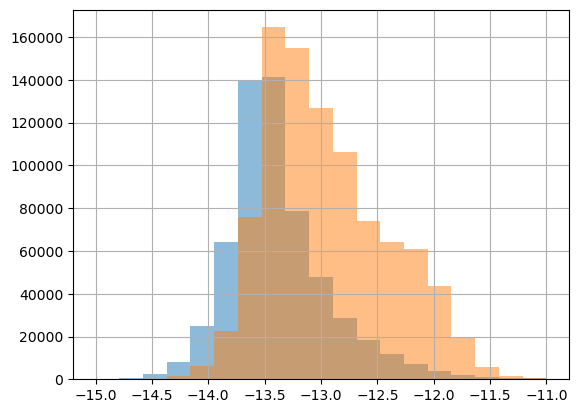

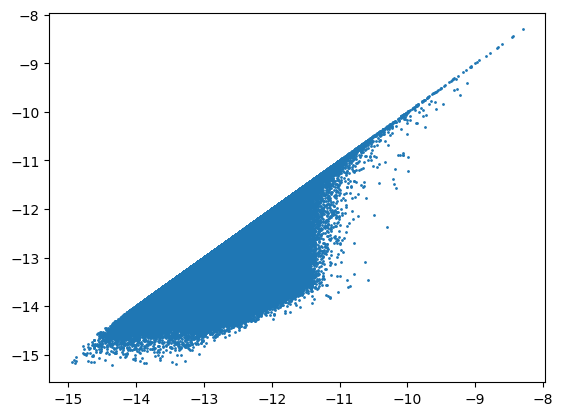

In [35]:
for x in range(1, 9):
    pct = sum(erass1[f'ML_FLUX_LOWERR_P{x}'] == erass1[f'ML_FLUX_P{x}'])/len(erass1)
    print(f"BAND {x}:  {pct*100:.2f}% where FLUX_LOWERR == FLUX")

log_new_Fx = np.log10(((erass1[[f'DET_LIKE_P{x}' for x in range(1, 6)]] >= 7).astype(int) *  erass1[[f'ML_FLUX_P{x}' for x in range(1, 6)]].values).sum(axis=1))
log_old_Fx = (np.log10(erass1[[f'ML_FLUX_P{x}' for x in range(1, 6)]].sum(axis=1)))

log_new_Fx.hist(bins = np.linspace(-15, -11, 20), alpha=.5)
log_old_Fx.hist(bins = np.linspace(-15, -11, 20), alpha=.5)

plt.show()

plt.scatter(log_old_Fx, log_new_Fx, s=1)
plt.show()

In [36]:
erass1['flux'] = ((erass1[[f'DET_LIKE_P{x}' for x in range(1, 6)]] >= 7).astype(int) *  erass1[[f'ML_FLUX_P{x}' for x in range(1, 6)]].values).sum(axis=1)

In [37]:
erass1.rename({'IAUNAME':'name', 'RA':'ra', 'DEC':'dec', 'RADEC_ERR':'e_pos'}, axis=1, inplace=True)

In [38]:
dp1_erass1 = pd.concat([get_box(name, coords, erass1) for name, coords in FIELDS.items()])


51.4295643168973 < ra < 54.830435683102706
56.82592280930308 < ra < 61.37407719069692
36.348799939622026 < ra < 39.37120006037797
93.34493312155627 < ra < 96.65506687844373
1.1449439201695437 < ra < 10.895056079830455
38.18098067763386 < ra < 41.81901932236614


Only take non-zero flux. Note we are dropping some detections because of our imposition that the source must be well detected in one of the first 5 bands

In [39]:

dp1_erass1 = dp1_erass1[dp1_erass1['flux'] > 1e-99]

In [40]:
dp1_erass1['cat'] = 'eRASS1'

In [41]:
data_dict['eRASS1'] = dp1_erass1

In [42]:
data_dict.keys()

dict_keys(['CSC2.1', '4XMMDR14', 'XMMSL3', '2SXPS', 'eRASS1'])

In [43]:
for key in data_dict.keys():
    data_dict[key]['cat'] = key

## Combine 

In [44]:
from astropy.coordinates import SkyCoord
import astropy.units as u

In [45]:
combined = []
for key, data in data_dict.items():
    combined.append(data_dict[key][['name', 'ra', 'dec', 'e_pos', 'field', 'cat', 'flux']])
combined = pd.concat(combined)

In [46]:
combined.rename({'e_pos': 'e_pos_raw', 'flux': 'F_X'}, axis=1, inplace=True)

## Apply corrections to get 1 sigma error radius

In [47]:
surveys = ['CSC2.1', '4XMMDR14', 'XMMSL3', '2SXPS', 'eRASS1']
corr = {'CSC2.1': 1.960, # 95% CI
        '4XMMDR14': .933, 
        'XMMSL3': 1, 
        '2SXPS': 1.645, # 90% CI
        'eRASS1': 1}

combined['e_pos_1sig'] = -1
for survey in surveys:
    combined.loc[combined['cat'] == survey, 'e_pos_1sig'] = combined.loc[combined['cat'] == survey, 'e_pos_raw'] / corr[survey]
    

In [48]:
combined['e_pos_95'] = 1.960 * combined['e_pos_1sig']

<Axes: >

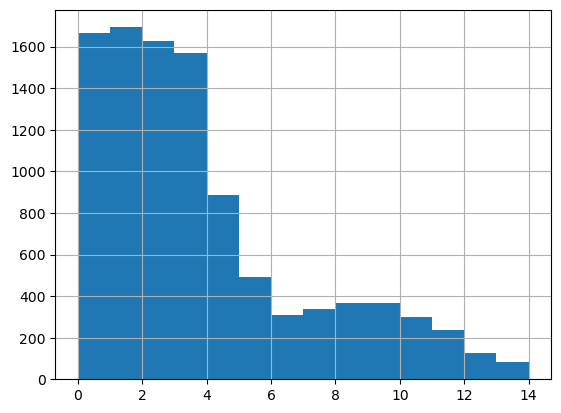

In [49]:
combined['e_pos_95'].hist(bins=np.arange(0, 15, 1))

In [50]:
combined['name'] = combined['name'].str.strip()
len(combined)


10307

In [51]:
combined.to_csv('../../data/intermediate_data_products/combined_xray_catalog.csv', index=False)

# Deduplicate and use tract patch to eliminate unobserved x-ray sources

In [52]:
combined = pd.read_csv('../../data/intermediate_data_products/combined_xray_catalog.csv')
combined['name'] = combined['name'].str.strip()

In [53]:
xray_df = combined.copy()

surveys = ['CSC2.1', '4XMMDR14', 'XMMSL3', '2SXPS', 'eRASS1']

data_by_survey = {}
for survey in surveys:
    data_by_survey[survey] = combined.query(f'cat == "{survey}"')

In [54]:
pairs = []
for i, (catnamei, cat_i) in enumerate(data_by_survey.items()):
    for j, (catnamej, cat_j) in enumerate(data_by_survey.items()):
        if i > j:
            # import pdb; pdb.set_trace()
            # print(f'{catnamei}: {catnamej}')
            cat_i_sc = SkyCoord(ra=cat_i['ra'], 
                             dec=cat_i['dec'],
                             frame='icrs', 
                             unit=(u.deg))
            cat_j_sc = SkyCoord(ra=cat_j['ra'], 
                 dec=cat_j['dec'],
                 frame='icrs', 
                 unit=(u.deg))
            idx, d2d, _ = cat_i_sc.match_to_catalog_sky(cat_j_sc, nthneighbor=1)
            sep_constraint = d2d < (np.maximum(cat_i['e_pos_95'].values, cat_j.iloc[idx]['e_pos_95'].values) * u.arcsec)
            # sep_constraint = d2d < (cat_i['e_pos_95'].values * u.arcsec)
            tot_match = np.sum(sep_constraint)
            pct_match1 = tot_match/len(cat_i_sc)
            pct_match2 = tot_match/len(cat_j_sc)
            print(f"{catnamei}: {catnamej}: {len(cat_i_sc)}-{len(cat_j_sc)}: {tot_match} ({pct_match1*100:.1f}%, {pct_match2*100:.1f}%)")
            
            overlapi = cat_i[sep_constraint]
            overlapj = cat_j.iloc[idx][sep_constraint]
            pairs.append((overlapi, overlapj))
            

4XMMDR14: CSC2.1: 5672-1936: 464 (8.2%, 24.0%)
XMMSL3: CSC2.1: 343-1936: 17 (5.0%, 0.9%)
XMMSL3: 4XMMDR14: 343-5672: 53 (15.5%, 0.9%)
2SXPS: CSC2.1: 385-1936: 178 (46.2%, 9.2%)
2SXPS: 4XMMDR14: 385-5672: 158 (41.0%, 2.8%)
2SXPS: XMMSL3: 385-343: 10 (2.6%, 2.9%)
eRASS1: CSC2.1: 1971-1936: 44 (2.2%, 2.3%)
eRASS1: 4XMMDR14: 1971-5672: 216 (11.0%, 3.8%)
eRASS1: XMMSL3: 1971-343: 52 (2.6%, 15.2%)
eRASS1: 2SXPS: 1971-385: 77 (3.9%, 20.0%)


#### Notes to self
- cat_i and cat_j change every loop, but not the stuff after the conditional

- Looks like very few X-ray objects have many matches. We can perhaps just take all the sources for which this is only one counterpart between catalogs and deduplicate assuming each match is true. We can then remove all objects for which there are one to many matches from both catalogs.

In [55]:
def dedup_pairs(df1, df2, xray_df, dropped_idx):
    '''keep source with smaller positional undertainty'''
    keep1 = df1['e_pos_95'].values < df2['e_pos_95'].values
    idx_delete1 = df1.index[~keep1]
    idx_delete2 = df2.index[keep1]
    to_drop = [x for x in df1.index if x in idx_delete1] + [x for x in df2.index if x in idx_delete2]
    to_drop = [x for x in to_drop if x not in dropped_idx]
    xray_df.drop(to_drop, inplace=True)
    return to_drop

In [56]:
xray_df = combined.copy()
dropped_idx = []

for i, pair in enumerate(pairs):
    print(i)
    dropped = dedup_pairs(pair[0], pair[1], xray_df, dropped_idx)
    dropped_idx = dropped + dropped_idx

0
1
2
3
4
5
6
7
8
9


### deduplicate objects with the same name

In [57]:
dup_names = xray_df[xray_df.duplicated(['name'], keep=False)].sort_values('name')['name'].unique() # keep smallest error
xray_df[xray_df.duplicated(['name'], keep=False)].sort_values('name')

,name,ra,dec,e_pos_raw,field,cat,F_X,e_pos_1sig,e_pos_95
7900,XMMSL3 J001725.3-715036,4.357769,-71.841587,4.456539,47Tuc,XMMSL3,2.472534e-12,4.456539,8.734816
7911,XMMSL3 J001725.3-715036,4.346433,-71.842288,5.214094,47Tuc,XMMSL3,4.151491e-12,5.214094,10.219624
7920,XMMSL3 J001725.3-715036,4.355830,-71.843223,3.079998,47Tuc,XMMSL3,3.686499e-12,3.079998,6.036796
7926,XMMSL3 J001725.3-715036,4.350684,-71.846862,6.302625,47Tuc,XMMSL3,3.411720e-12,6.302625,12.353145
7946,XMMSL3 J024251.4-342849,40.714072,-34.480397,3.993086,Fornax_dSph,XMMSL3,7.707960e-12,3.993086,7.826449
7949,XMMSL3 J024251.4-342849,40.714267,-34.480306,3.927990,Fornax_dSph,XMMSL3,7.581600e-12,3.927990,7.698860
7658,XMMSL3 J033246.4-283929,53.193418,-28.657986,4.712936,ECDFS,XMMSL3,4.106700e-13,4.712936,9.237355
7659,XMMSL3 J033246.4-283929,53.193445,-28.658192,4.783375,ECDFS,XMMSL3,4.106700e-13,4.783375,9.375415
7695,XMMSL3 J033331.9-270915,53.383922,-27.152745,1.946616,ECDFS,XMMSL3,5.022810e-12,1.946616,3.815367
7739,XMMSL3 J033331.9-270915,53.381829,-27.155120,1.990644,ECDFS,XMMSL3,1.800630e-12,1.990644,3.901662


In [58]:
xray_df = xray_df.sort_values('e_pos_95', ascending=True).drop_duplicates(['name'], keep='first')
len(xray_df)

9248

### only keep sources with 95% confidence positional uncertainty < 15 arcsecs

In [59]:
xray_df = xray_df[xray_df['e_pos_95'] < 15]
len(xray_df)

9089

### Get tract and patch of all DP1 observed fields
#### run on usdf only--requires skymap and all products ot type deep_coadd_n_image 

In [60]:
# from lsst.daf.butler import Butler

# butler = Butler("dp1", collections="LSSTComCam/DP1")
# registry = butler.registry
# skymap = butler.get('skyMap', dataId={'skymap': 'lsst_cells_v1'})

# dataId = {'instrument': 'LSSTComCam'} 
# refs = registry.queryDatasets("deep_coadd_n_image", dataId=dataId)
# len(list(refs))

# tps = []
# n = 0
# for ref in list(refs):
#     n+=1
#     if n % 100 == 0:
#         print(n)
#     test = butler.get(list(refs)[0])
#     if sum(sum(test.array)) > 0:
#         dataId = ref.dataId
#         tps.append({'tract': ref.dataId['tract'], 'patch': ref.dataId['patch']})

# tps = pd.DataFrame(tps).drop_duplicates()
# tps.to_csv('../../data/intermediate_data_products/all_tracts_patches_dp1.csv', index=False)

# tps['tract'].sort_values().unique()

In [61]:
tps =  pd.read_csv('../../data/intermediate_data_products/all_tracts_patches_dp1.csv')

#### find tract and patch of each x-ray source and only keep if in DP1 observed tract/patch

In [62]:
from lsst.geom import SpherePoint, degrees
from lsst.daf.butler import Butler

butler = Butler("dp1", collections="LSSTComCam/DP1")
registry = butler.registry
skymap = butler.get('skyMap', dataId={'skymap': 'lsst_cells_v1'})

def get_tract_patch(ra, dec, skymap):
    my_spherePoint = SpherePoint(ra*degrees, dec*degrees)
    
    tract = skymap.findTract(my_spherePoint)
    patch = tract.findPatch(my_spherePoint)
    
    my_tract = tract.tract_id
    my_patch = patch.getSequentialIndex()

    return my_tract, my_patch

tracts = []
patches = []
for _, row in xray_df.iterrows():
    tract, patch = get_tract_patch(row['ra'], row['dec'], skymap)
    tracts.append(tract)
    patches.append(patch)

xray_df['tract'] = tracts
xray_df['patch'] = patches

# make list of "hashes"
tp_str = [f'{row['tract']}_{row['patch']}' for i, row in tps.iterrows()]

is_in_dp1 = [f'{row['tract']}_{row['patch']}' in tp_str for i, row in xray_df.iterrows()]
xray_df['DP1_flag'] = is_in_dp1

print(xray_df['DP1_flag'].sum())
# # Check if 0
# print(sum(xray_df[~xray_df['DP1_flag']]['obj_flag']))
# print(sum(xray_df[~xray_df['DP1_flag']]['dia_flag']))

# # Check nonzero
# print(sum(xray_df[xray_df['DP1_flag']]['obj_flag']))
# print(sum(xray_df[xray_df['DP1_flag']]['dia_flag']))

4481


In [63]:
print(xray_df['DP1_flag'].sum())
xray_df = xray_df[xray_df['DP1_flag']]

4481


In [64]:
xray_df.to_csv('../../data/intermediate_data_products/xray_in_DP1_patches.csv', index=False)

# Save smaller catalogs in data_dict

In [65]:
xray_df = pd.read_csv('../../data/intermediate_data_products/xray_in_DP1_patches.csv')

In [66]:
len(xray_df)

4481

In [67]:
xray_df['cat'].value_counts()

cat
4XMMDR14    2552
CSC2.1      1554
eRASS1       257
2SXPS         60
XMMSL3        58
Name: count, dtype: int64

In [68]:
for cat in data_dict.keys():
    sub = data_dict[cat]
    sub = sub[sub['name'].str.strip().isin(xray_df['name'].values)]
    sub['name'] = sub['name'].str.strip()
    if cat == 'XMMSL3':
        # deduplicate names
        sub = sub.sort_values('e_pos', ascending=True).drop_duplicates(['name'], keep='first')
    sub.to_csv(f'../../data/intermediate_data_products/full_xray/{cat}_dp1_patches.csv', index=False)
    print(cat, sub.shape)

CSC2.1 (1554, 77)
4XMMDR14 (2552, 49)
XMMSL3 (58, 112)
2SXPS (60, 234)
eRASS1 (257, 255)
